##### Expand View


In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:88% !important; }</style>"))

In [8]:
# Exploring MNIST Gans

import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST  # Training dataset
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/mnist_experiment_1')

import matplotlib.pyplot as plt
# import wandb

from markipy.nn.gans.generator import get_gen_loss, Generator
from markipy.nn.gans.discriminator import get_disc_loss, Discriminator
from markipy.nn.commons import show_tensor_images, make_noise, scale_noise_by_label_number

torch.manual_seed(0)  # Set for testing purposes, please do not change!

PROJECT="MNIST"


## Hyperparameters

In [9]:
    # Mnist Playground
    device = torch.device('cuda')
    n_epochs = 5
    z_dim = 64
    display_step = 468
    batch_size = 128
    lr = 0.00001
    cur_step = 0
    mean_generator_loss = 0
    mean_discriminator_loss = 0
    test_generator = False  # Whether the generator should be tested
    gen_loss = False
    error = False

## Load Data

In [10]:
    # Load MNIST dataset as tensors
    dataloader = DataLoader(
        MNIST('.', download=True, transform=transforms.ToTensor()),
        batch_size=batch_size,
        shuffle=True)

## Core

In [11]:
    criterion = nn.BCEWithLogitsLoss()
    gen = Generator(z_dim).to(device)
    gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
    disc = Discriminator().to(device)
    disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

## View Input Data

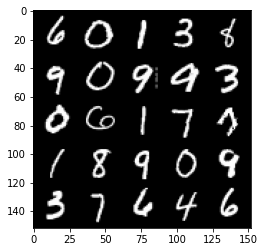

torch.Size([128, 1, 28, 28]) torch.Size([128]) tensor([6, 0, 1, 3, 8, 9, 0, 9, 9, 3, 0, 6, 1, 7, 7, 1, 8, 9, 0, 9, 3, 7, 6, 4,
        6])


In [12]:
for x,y in dataloader:
    show_tensor_images(x, num_images=25)
    print(x.shape, y.shape, y[:25])
    break
    

# Train - 1 Step

Epoch 0, step 2808: Generator loss: 1.8856145752291391, discriminator loss: 0.1705251563276746


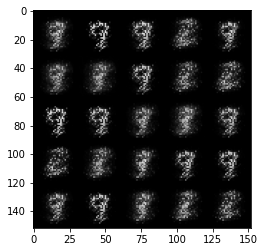

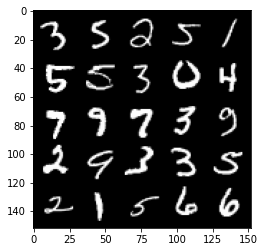

Epoch 1, step 3276: Generator loss: 2.304764776657789, discriminator loss: 0.12326703476918559


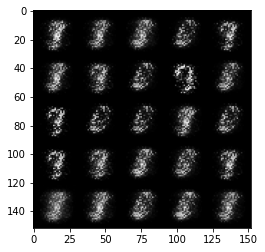

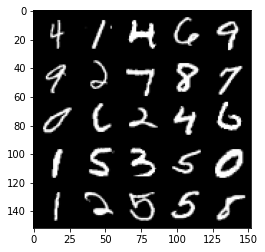

Epoch 2, step 3744: Generator loss: 2.5512778539942884, discriminator loss: 0.09549361077320366


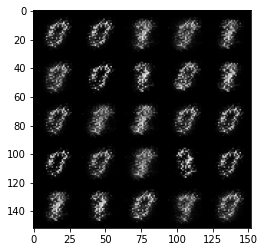

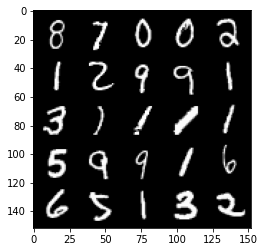

Epoch 3, step 4212: Generator loss: 2.7591130152726793, discriminator loss: 0.08866423355717938


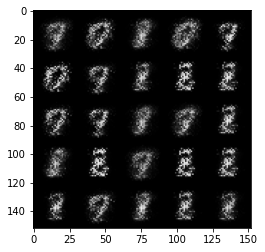

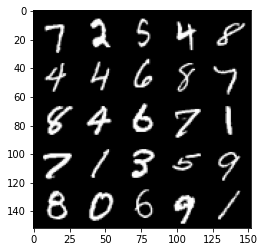

Epoch 4, step 4680: Generator loss: 2.913739313427198, discriminator loss: 0.08063639713944781


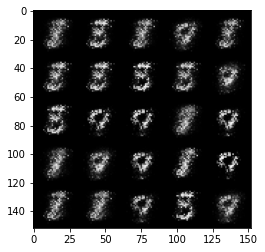

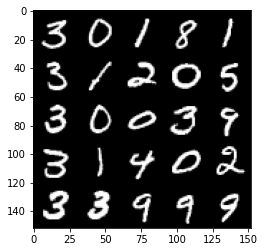

In [14]:
disc_init = False
for epoch in range(n_epochs):
    
    # Dataloader returns the batches
    for real, label in tqdm(dataloader):
        cur_batch_size = len(real)

        # Flatten the batch of real images from the dataset
        real = real.view(cur_batch_size, -1).to(device)

        if cur_step % 28: 
            ### Update discriminator ###
            # Zero out the gradients before backpropagation
            disc_opt.zero_grad()

            # Calculate discriminator loss
            disc_loss = get_disc_loss(gen, disc, criterion, real, label, cur_batch_size, z_dim, device)

            # Update gradients
            disc_loss.backward(retain_graph=True)

            # Update optimizer
            disc_opt.step()
            
            disc_init = True

        # For testing purposes, to keep track of the generator weights
        if test_generator:
            old_generator_weights = gen.gen[0][0].weight.detach().clone()

        # Update gradients
        gen_opt.zero_grad()

        # Update optimizer
        gen_loss = get_gen_loss(gen, disc, criterion, label, cur_batch_size, z_dim, device)

        # Update gradients
        gen_loss.backward(retain_graph=True)

        # Update optimizer
        gen_opt.step()

        # For testing purposes, to check that your code changes the generator weights
        if test_generator:
            try:
                assert lr > 0.0000002 or (gen.gen[0][0].weight.grad.abs().max() < 0.0005 and epoch == 0)
                assert torch.any(gen.gen[0][0].weight.detach().clone() != old_generator_weights)
                
            except:
                error = True
                
                # wandb.log({"no_training": 1, "epoch": epoch, "loss": loss})
                print("Runtime tests have failed")

        if disc_init:
            # Keep track of the average discriminator loss
            mean_discriminator_loss += disc_loss.item() / display_step

        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step

        ### Visualization code ###
        if cur_step % display_step == 0 and cur_step > 0:

            # wandb.log({ "Epoch" : epoch, "step": cur_step , "Generator_Loss" : mean_generator_loss, "Discriminator_Loss": mean_discriminator_loss })
            print(f"Epoch {epoch}, step {cur_step}: Generator loss: {mean_generator_loss if disc_init else 'nan'}, discriminator loss: {mean_discriminator_loss}")

            noise = make_noise(cur_batch_size, z_dim, device=device)
            fake = gen(noise)
            
            show_tensor_images(fake)
            show_tensor_images(real)
            
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        
        # Increase step
        cur_step += 1
    
        
        
# Shift + o  : To show scroll the ouput 

In [99]:
labe

tensor([3, 2, 1, 9, 1, 9, 1, 0, 9, 2, 2, 7, 6, 1, 9, 7, 7, 7, 2, 2, 6, 9, 7, 4,
        9, 9, 0, 4, 3, 4, 2, 2, 0, 9, 0, 0, 6, 6, 7, 9, 7, 7, 6, 4, 2, 6, 5, 9,
        1, 1, 0, 4, 4, 4, 7, 3, 0, 4, 5, 4, 5, 3, 3, 1, 6, 1, 2, 7, 3, 8, 2, 0,
        3, 6, 4, 7, 7, 7, 9, 0, 4, 7, 5, 2, 7, 3, 2, 7, 1, 2, 5, 1, 4, 2, 2, 7])

In [140]:

noise.shape,label.shape


(torch.Size([96, 64]), torch.Size([96]))

In [126]:
label = label.view(1,96)
label.shape

torch.Size([1, 96])

In [125]:
for i in range(len(noise)):
    noise[i,:]  = noise[i,:] * label[i]
    

RuntimeError: The size of tensor a (64) must match the size of tensor b (96) at non-singleton dimension 0

In [127]:
noise.shape[0]

96

In [128]:
noise 

tensor([[  5.8364,  -0.8554,  -4.8961,  ...,  -2.6881,   1.5661,  -1.0836],
        [ -1.9690,  -0.8397,   0.1495,  ...,  -0.4971,  -0.9656,  -0.4614],
        [ -0.5164,  -0.0514,  -0.0767,  ...,   1.3109,   0.4441,  -0.3118],
        ...,
        [ -3.5915,   1.0974,  -4.1473,  ...,  -0.1931,   0.3260,   2.9142],
        [ -0.1631,  -0.4615,   0.4026,  ...,  -1.5692,   0.3559,  -1.2657],
        [  0.8674,  -3.8274,   0.6125,  ..., -16.3919,   9.3295,   4.3215]],
       device='cuda:0')

In [141]:
def scale_noise_by_label_number(noise, label):
    for i in range(len(noise)):
        noise[i,:]  = noise[i,:] * label.view(noise.shape[0], 1)[i,:].item()
    return noise

scale_noise_by_label_number(noise, label)

tensor([[ -7.5995,   9.8047,   8.4670,  ...,  -4.6198,   0.0357,  -7.8365],
        [  4.4098,  -5.2633,   1.2401,  ...,   2.7777,   5.7937,   0.1103],
        [  0.9839,  -2.1432,   4.5317,  ...,   5.5288,   1.0878,   3.2746],
        ...,
        [  0.7502,   5.8612,   3.1926,  ...,   3.4684,  -6.8339,   1.6456],
        [  5.8509,  -3.0717,  -3.8928,  ...,  -2.1160,  -2.2324,   3.3840],
        [ -4.7151,   9.1105,  -9.7705,  ...,  15.2673, -16.3235,  -8.4438]],
       device='cuda:0')